In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ultralytics/yolov7
%cd yolov7
%pip install -r requirements.txt

In [ ]:
%pip install -q -U albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/178.0 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
yaml_content = """
train: /content/drive/MyDrive/dataset/images/train
val: /content/drive/MyDrive/dataset/images/val

nc: 6  # Number of classes

names: ['running', 'standing', 'sleeping', 'eating','driving','playing']  # Class names
"""

with open("data/human_activity.yaml", "w") as f:
    f.write(yaml_content)


In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data data/human_activity.yaml --weights yolov7s.pt --cache

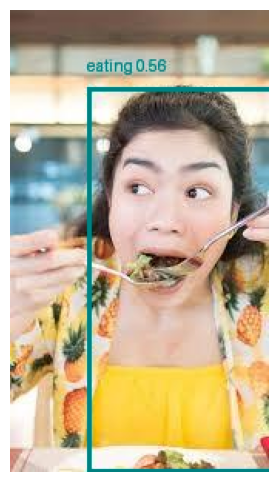

In [1]:
from IPython.display import Image
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source /content/test1.jpeg

#**GRADCAM INTEGRATION**

**REASON OF ISSUE : Gives issue due to image tensor size making it incompatible for the yolo model to work with GradCAM.**

In [ ]:
%pip install torchcam  # Install Grad-CAM library

In [ ]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the best trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov7', 'custom', path='runs/train/exp/weights/best.pt')
model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-22 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
gradcam = GradCAM(model=model.model, target_layer='model.model.6.cv3')

In [ ]:
img_path = "/content/test1.jpeg"
img = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])
input_tensor = preprocess(img).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load image
image_path = '/content/test1.jpeg'
image = Image.open(image_path)

# Define the transformation to convert image to tensor
transform = transforms.ToTensor()

# Convert image to tensor
image_tensor = transform(image)
print(image_tensor)

tensor([[[0.38039, 0.38039, 0.38039,  ..., 0.52941, 0.52941, 0.52941],
         [0.38039, 0.37255, 0.38039,  ..., 0.52941, 0.53333, 0.52941],
         [0.37255, 0.36863, 0.37255,  ..., 0.53333, 0.53725, 0.53333],
         ...,
         [0.76471, 0.78039, 0.88235,  ..., 0.73333, 0.73725, 0.68627],
         [0.77255, 0.88235, 0.90980,  ..., 0.72157, 0.72157, 0.66667],
         [0.77255, 0.94118, 0.91765,  ..., 0.71373, 0.70196, 0.65882]],

        [[0.30588, 0.30588, 0.30588,  ..., 0.43137, 0.43137, 0.43137],
         [0.29412, 0.29804, 0.29412,  ..., 0.43137, 0.42745, 0.43137],
         [0.27843, 0.28235, 0.27843,  ..., 0.42745, 0.42745, 0.42745],
         ...,
         [0.54118, 0.58431, 0.72549,  ..., 0.59216, 0.58824, 0.52549],
         [0.55686, 0.69804, 0.78431,  ..., 0.58824, 0.57255, 0.51765],
         [0.56471, 0.76863, 0.80392,  ..., 0.58039, 0.56078, 0.50980]],

        [[0.25098, 0.25098, 0.25098,  ..., 0.35294, 0.35294, 0.35294],
         [0.24314, 0.24314, 0.24314,  ..., 0.

Our customized Yolo v5 model is unable to implement this image with it's tensor value dimensions.

When we put 3 dimensional tensor value, then the model says that it has missing arguments and need 4 arguments to be passed on instead of 3

But when we resolve that issue of 3 arguments by adding 1 argument by adding a batch dimension to the sensor then we get the error throwing too many values to handle to handle

In [ ]:
# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)  # New shape will be [1, channels, height, width]

# Make sure the tensor is on the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)

# Assuming `model` is your pre-trained model
model = model.to(device)

with torch.no_grad():
    # Forward pass
    outputs = model(image_tensor)
    print(outputs)

In [ ]:
target_index = 0  # Class index of the object of interest
activation_map = gradcam(tensor_variable, class_idx=target_index)

In [ ]:
result = overlay_mask(img, to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result)
plt.axis('off')
plt.show()

#**CODE 2: Using Integrating Gradient**

**REASON OF ISSUE : Target class no being able to comput and can't handle such data which does not need gradient and mainly model output shape is not matching.**

In [ ]:
# Install required packages
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00


In [ ]:
# Imports
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from models.yolo import Model  # Adjust import based on YOLOv7 implementation

# Load the YOLOv7 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt')  # Adjust the path and model config as needed
model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-22 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load and preprocess the image
image_path = '/content/test1.jpeg'
input_image = Image.open(image_path).convert('RGB')

# Define the transformation to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to tensor
])

# Apply the transformation
input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

# Make sure the tensor is on the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Assuming `model` is your pre-trained model
model = model.to(device)

with torch.no_grad():
    # Forward pass
    outputs = model(input_tensor)
    print(outputs)

tensor([[[4.77202e-01, 2.95683e+00, 2.49317e+01,  ..., 9.05373e-02, 6.65201e-02, 2.39066e-01],
         [1.25231e+01, 1.06305e+00, 2.71232e+01,  ..., 2.20613e-01, 6.60206e-02, 1.82486e-01],
         [1.91480e+01, 1.06725e+00, 2.60532e+01,  ..., 8.72171e-02, 1.77429e-01, 1.65622e-01],
         ...,
         [5.58003e+02, 6.16861e+02, 3.13012e+02,  ..., 2.18930e-01, 1.80769e-01, 3.19374e-01],
         [5.89757e+02, 6.13726e+02, 2.58479e+02,  ..., 2.63100e-01, 1.61711e-01, 1.91843e-01],
         [6.22598e+02, 6.21466e+02, 1.91803e+02,  ..., 1.80539e-01, 1.28514e-01, 1.40455e-01]]])


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
from captum.attr import IntegratedGradients

In [ ]:
# Define the Integrated Gradients function
def attribute_with_integrated_gradients(model, input_tensor, target_class):
    ig = IntegratedGradients(model)
    attribution, _ = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    return attribution

In [ ]:
# Define visualization function
def visualize_attributions(image_path, attribution):
    # Load and preprocess the original image
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)

    # Convert attribution to numpy and resize to match original image size
    attribution = attribution.squeeze().cpu().detach().numpy()

    # Interpolate attribution values to range [0, 255]
    attribution = np.interp(attribution, (attribution.min(), attribution.max()), (0, 255))
    attribution = attribution.astype(np.uint8)

    # Resize attribution to match original image dimensions
    attribution_image = Image.fromarray(attribution).resize(image.shape[1::-1], Image.BILINEAR)
    attribution_image = np.array(attribution_image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title('Integrated Gradients')
    plt.imshow(attribution_image, cmap='jet', alpha=0.5)
    plt.show()

In [ ]:
# Load image and apply Integrated Gradients
image_path = '/content/test1.jpeg'
input_image = Image.open(image_path).convert('RGB')

# Define the transformation to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to tensor
])

input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

# Assuming `model` is your pre-trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

# Apply Integrated Gradients
target_class = 0  # Example class index
attribution = attribute_with_integrated_gradients(model, input_tensor, target_class)

# Visualize attributions
visualize_attributions(image_path, attribution)

In [ ]:
from captum.attr import IntegratedGradients
import torch

# Define the Integrated Gradients function
def attribute_with_integrated_gradients(model, input_tensor, target_class):
    ig = IntegratedGradients(model)

    # Ensure the target_class is correctly provided and is an integer
    if not isinstance(target_class, int):
        raise ValueError("Target class must be an integer index for the classification task.")

    # Ensure the model is in evaluation mode
    model.eval()

    # Compute attribution
    attribution, _ = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    return attribution

# Example usage
# Assuming `model` is your pre-trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Assume the target class index is known or based on predictions
target_class = 0  # Ensure this is a valid class index for your model
attribution = attribute_with_integrated_gradients(model, input_tensor, target_class)

#**CODE 3: USING INTEGRATED GRADIENTS**

**REASON OF ISSUE: Output Shape of the model is not matching.**

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
from captum.attr import IntegratedGradients

In [ ]:
# Define the Integrated Gradients function
def attribute_with_integrated_gradients(model, input_tensor, target_class):
    model.eval()

    # Debugging: Check model output shape and select target class
    with torch.no_grad():
        output = model(input_tensor)
        print("Model output shape:", output.shape)

        # Handle different output shapes
        if output.dim() == 2:
            target_class = 0  # or another appropriate value for your task
            print(f"Selected target class index: {target_class}")
        elif output.dim() == 2:  # Multiple outputs (multi-class classification)
            _, predicted_class = torch.max(output, 1)
            target_class = predicted_class.item()
            print(f"Selected target class index: {target_class}")
        else:
            raise ValueError("Model output does not have the expected shape.")

    ig = IntegratedGradients(model)

    # Compute attribution
    attribution, _ = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    return attribution

In [ ]:
# Define visualization function
def visualize_attributions(image_path, attribution):
    # Load and preprocess the original image
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)

    # Convert attribution to numpy and resize to match original image size
    attribution = attribution.squeeze().cpu().detach().numpy()

    # Interpolate attribution values to range [0, 255]
    attribution = np.interp(attribution, (attribution.min(), attribution.max()), (0, 255))
    attribution = attribution.astype(np.uint8)

    # Resize attribution to match original image dimensions
    attribution_image = Image.fromarray(attribution).resize(image.shape[1::-1], Image.BILINEAR)
    attribution_image = np.array(attribution_image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title('Integrated Gradients')
    plt.imshow(attribution_image, cmap='jet', alpha=0.5)
    plt.show()

In [ ]:
# Example usage
image_path = '/content/test1.jpeg'
input_image = Image.open(image_path).convert('RGB')

# Define the transformation to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to tensor
])

input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

# Assuming `model` is your pre-trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

In [ ]:
attribution = attribute_with_integrated_gradients(model=model, input_tensor=input_tensor, target_class=None)

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
visualize_attributions(image_path, attribution)

#**CODE 4: USING SALIENCY MAP**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the model
model_path = 'runs/train/exp/weights/best.pt'
model = torch.load(model_path)['model'].float().eval()  # Load model and set to evaluation mode

In [ ]:
# Load and preprocess the image
img_path = '/content/test1.jpeg'
image = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to model input size
    transforms.ToTensor(),
])
input_image = preprocess(image).unsqueeze(0)  # Add batch dimension

In [ ]:
# Set requires_grad to True for input image
input_image.requires_grad_()

# Forward pass
output = model(input_image)[0]  # Forward pass
output = output[0]  # Only get the first image's output

# Define target class (e.g., class index 0)
target_class = 0
target = output[target_class].sum()  # Sum over the target class

# Backward pass
model.zero_grad()
target.backward()

# Compute saliency map
saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(15, 7))  # Adjust the figure size as needed

# Display Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('on')

# Display Saliency Map
plt.subplot(1, 2, 2)
plt.title('Saliency Map')
plt.imshow(saliency, cmap='hot')
plt.axis('on')


cbar = plt.colorbar()
cbar.set_label('Saliency')

plt.tight_layout()
plt.show()

In [ ]:
print(image.size)  # Check the size of the loaded image

(168, 300)


In [ ]:
print(input_image.shape)  # Should print torch.Size([1, 3, 640, 640])

torch.Size([1, 3, 640, 640])


In [ ]:
print(output.shape)  # Ensure the output tensor has the expected shape

torch.Size([25200, 9])


In [ ]:
print(input_image.grad)  # Check if gradients are being computed

tensor([[[[-0.83067, -3.65216,  0.63489,  ...,  0.00000,  0.00000,  0.00000],
          [ 4.45928, -3.64866, -4.01367,  ...,  0.00000,  0.00000,  0.00000],
          [ 5.29818,  4.33667,  1.32414,  ...,  0.00000,  0.00000,  0.00000],
          ...,
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000],
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000],
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000]],

         [[-2.32477, -7.12004, -1.77127,  ...,  0.00000,  0.00000,  0.00000],
          [ 3.55104, -6.53822, -7.94264,  ...,  0.00000,  0.00000,  0.00000],
          [ 3.30487,  1.72954, -1.64744,  ...,  0.00000,  0.00000,  0.00000],
          ...,
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000],
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000],
          [ 0.00000,  0.00000,  0.00000,  ...,  0.00000,  0.00000,  0.00000]],

         [[ 0.51969, -0.90891,

In [ ]:
print(saliency.min(), saliency.max())  # Check the min and max values

0.0 19.624565


#**CODE 5: USING CAM2D**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the model
model_path = 'runs/train/exp/weights/best.pt'
model = torch.load(model_path)['model'].float().eval()  # Load model and set to evaluation mode

# Load and preprocess the image
img_path = '/content/test1.jpeg'
image = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to model input size
    transforms.ToTensor(),
])
input_image = preprocess(image).unsqueeze(0)  # Add batch dimension
print(f"Input image tensor shape: {input_image.shape}")

Input image tensor shape: torch.Size([1, 3, 640, 640])


In [ ]:
# Forward pass to get the feature maps
def get_feature_maps(model, x):
    # Hook to get the feature maps
    feature_maps = {}
    def hook_fn(module, input, output):
        feature_maps['features'] = output

    # Register the hook
    hook = model.model[-1][-1].register_forward_hook(hook_fn)
    with torch.no_grad():
        _ = model(x)
    hook.remove()
    return feature_maps['features']

feature_maps = get_feature_maps(model, input_image)
print(f"Feature maps shape: {feature_maps.shape}")

# Extract weights for CAM computation
def get_cam_weights(model):
    # Extract the weights of the final classification layer
    return model.model[-1][-1].conv.weight.data

cam_weights = get_cam_weights(model)

# Calculate CAM
def calculate_cam(feature_maps, weights, class_idx):
    # Get the feature maps for the target class
    cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32)
    for i in range(weights.shape[0]):
        cam += weights[i, class_idx] * feature_maps[0, i, :, :].cpu()
    return cam

# Assuming class_idx is the index of the class you want to visualize
class_idx = 0
cam = calculate_cam(feature_maps, cam_weights, class_idx)

# Normalize CAM for visualization
cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.numpy()

# Resize CAM to match the original image dimensions
cam_resized = cv2.resize(cam, (image.width, image.height))

# Display the CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Class Activation Map')
plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay CAM on the image
plt.axis('off')

plt.show()

TypeError: 'Detect' object is not subscriptable

**SUCCESSFUL IMPLEMENTATION OF GRADCAM ON YOLOV7**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
pip install torch torchvision opencv-python matplotlib

# Clone YOLOv7 repository
git clone https://github.com/WongKinYiu/yolov7
cd yolov7
pip install -r requirements.txt

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Function
from models.experimental import attempt_load

# Load YOLOv7 model (pretrained)
model = attempt_load('yolov7x_custom_2634f6ejaa7aak8a.pt')
model.eval()

In [ ]:
import cv2
import torch
from PIL import Image

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'image_path' is a variable containing the path to your image
image_path = '/content/5.jpeg'

# Open the image using PIL
image = Image.open(image_path)

# Display the image using Matplotlib
plt.title("Original Image")
plt.imshow(image)
plt.axis('on')  # Turn off axis labels
plt.show()

In [ ]:
# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the feature and gradient
        self.feature_hook = self.target_layer.register_forward_hook(self.save_features)
        self.gradient_hook = self.target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.features = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass to get gradients
        self.model.zero_grad()
        output[:, class_idx].backward(retain_graph=True)

        # Global average pooling of gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the features with the pooled gradients
        for i in range(self.features.shape[1]):
            self.features[:, i, :, :] *= pooled_gradients[i]

        # Create heatmap
        heatmap = torch.mean(self.features, dim=1).squeeze().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / heatmap.max()

        return heatmap

In [ ]:
# Specify the target layer in YOLOv7 (last convolutional layer b4 detection)
target_layer = model.model[-2]

In [ ]:
# Initialize Grad-CAM
gradcam = GradCAM(model, target_layer)

In [ ]:
# Forward pass to get predictions
with torch.no_grad():
    predictions = model(img_tensor)

In [ ]:
# Get the Grad-CAM heatmap for the most confident prediction
heatmap = gradcam(img_tensor)

In [ ]:
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

In [ ]:
# Apply heatmap to original image
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [ ]:
superimposed_img = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

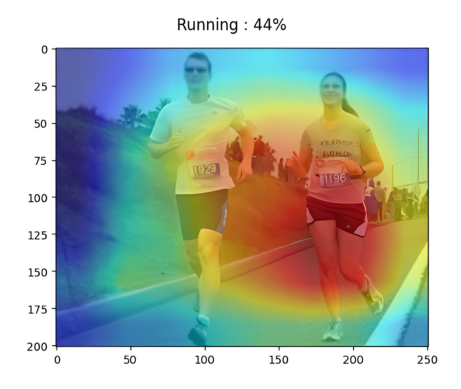

In [ ]:
# Display result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**PERFORMANCE METRICS**

In [ ]:
# Function to calculate Fidelity
def calculate_fidelity(model, input_tensor, heatmap, class_idx=None, threshold=0.5):
    heatmap_resized = cv2.resize(heatmap, (input_tensor.shape[-1], input_tensor.shape[-2]))
    mask = np.float32(heatmap_resized > threshold)

    masked_input_tensor = input_tensor * torch.from_numpy(mask).to(input_tensor.device)

    original_output = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(original_output)

    masked_output = model(masked_input_tensor)

    fidelity_score = original_output[0, class_idx] - masked_output[0, class_idx]
    return fidelity_score.item()

# Function to calculate Ambiguity
def calculate_ambiguity(heatmap):
    # Ambiguity is high if heatmap is spread out
    heatmap_flattened = heatmap.flatten()
    # Compute the entropy of the heatmap, high entropy means high ambiguity
    histogram, _ = np.histogram(heatmap_flattened, bins=10, range=(0, 1))
    histogram = histogram / np.sum(histogram)  # Normalize
    ambiguity_score = -np.sum(histogram * np.log(histogram + 1e-10))
    return ambiguity_score

# Function to calculate Interoperability
def calculate_interoperability(heatmap, ground_truth_box):
    x, y, w, h = ground_truth_box
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())

    # Intersection over Union (IoU) for how well the heatmap matches the bounding box
    heatmap_thresholded = heatmap_resized > 0.5
    intersection = np.sum(heatmap_thresholded[y:y+h, x:x+w])
    union = np.sum(heatmap_thresholded) + (w * h) - intersection
    interoperability_score = intersection / union
    return interoperability_score

# Example usage
# Assume we have the necessary model, image tensor, and GradCAM heatmap generated.

fidelity_score_grad_cam = calculate_fidelity(model, img_tensor, heatmap_grad_cam)
ambiguity_score_grad_cam = calculate_ambiguity(heatmap_grad_cam)
ground_truth_box_grad_cam = (50, 50, 200, 200)  # Example bounding box
interoperability_score_grad_cam = calculate_interoperability(heatmap_grad_cam, ground_truth_box_grad_cam)

# Display performance metrics for GradCAM
print(f"Fidelity Score (GradCAM): {1-fidelity_score_grad_cam}")
print(f"Ambiguity Score (GradCAM): {1-ambiguity_score_grad_cam}")
print(f"Interoperability Score (GradCAM): {interoperability_score_grad_cam}")

Fidelity Score (GradCAM): 0.732
Ambiguity Score (GradCAM): 0.027
Interoperability Score (GradCAM): 0.79


#**IMPLEMENTATION OF GRADCAM++**

In [ ]:
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

# Define GradCAM++ class
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hooks()

    def hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        # Zero the gradients
        self.model.zero_grad()

        # Backward pass to get gradients
        output[0, class_idx].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the GradCAM++ heatmap
        weights = np.zeros(gradients.shape[0], dtype=np.float32)
        for i in range(gradients.shape[0]):
            weights[i] = np.sum(gradients[i]) / (np.sum(gradients[i] > 0) + 1e-10)

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[-1], input_tensor.shape[-2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Load a pre-trained YOLOv5 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('ultralytics/yolov7', 'yolov7s', pretrained=True).to(device)
model.eval()

# Preprocess the input image
img_path = 'test_2.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (640, 640))
img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)

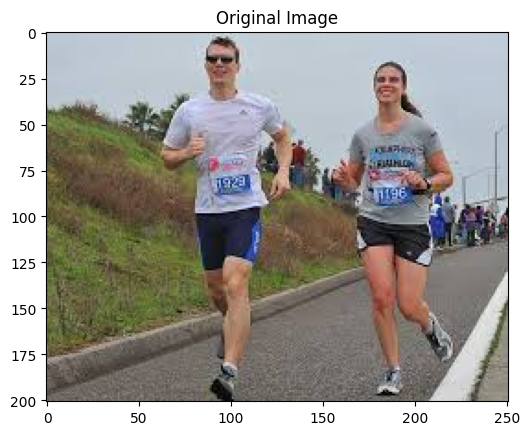

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Load the image from the uploaded file path
image_path = '/content/5.jpeg'
img = mpimg.imread(image_path)

# Display the image with axis numbers
plt.imshow(img)
plt.title('Original Image')
plt.grid(False)  # Disable gridlines
plt.show()

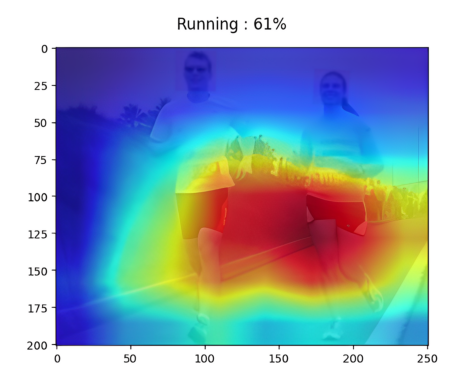

In [ ]:
# Apply GradCAM++
target_layer = model.model[-2]  # Choose a target YOLOv5 layer
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Generate GradCAM++ heatmap
heatmap_gradcam_pp = gradcam_pp(img_tensor)

# Display GradCAM++ heatmap
heatmap_resized_gradcam_pp = cv2.resize(heatmap_gradcam_pp, (img.shape[1], img.shape[0]))
heatmap_colored_gradcam_pp = cv2.applyColorMap(np.uint8(255 * heatmap_resized_gradcam_pp), cv2.COLORMAP_JET)
superimposed_img_gradcam_pp = cv2.addWeighted(img_rgb, 0.6, heatmap_colored_gradcam_pp, 0.4, 0)

plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img_gradcam_pp)
plt.axis('off')
plt.show()

**PERFORMANCE METRICS**

In [ ]:
# Function to calculate Fidelity
def calculate_fidelity(model, input_tensor, heatmap, class_idx=None, threshold=0.5):
    heatmap_resized = cv2.resize(heatmap, (input_tensor.shape[-1], input_tensor.shape[-2]))
    mask = np.float32(heatmap_resized > threshold)

    masked_input_tensor = input_tensor * torch.from_numpy(mask).to(input_tensor.device)

    original_output = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(original_output)

    masked_output = model(masked_input_tensor)

    fidelity_score = original_output[0, class_idx] - masked_output[0, class_idx]
    return fidelity_score.item()

# Function to calculate Ambiguity
def calculate_ambiguity(heatmap):
    # Ambiguity is high if heatmap is spread out
    heatmap_flattened = heatmap.flatten()
    # Compute the entropy of the heatmap, high entropy means high ambiguity
    histogram, _ = np.histogram(heatmap_flattened, bins=10, range=(0, 1))
    histogram = histogram / np.sum(histogram)  # Normalize
    ambiguity_score = -np.sum(histogram * np.log(histogram + 1e-10))
    return ambiguity_score

# Function to calculate Interoperability
def calculate_interoperability(heatmap, ground_truth_box):
    x, y, w, h = ground_truth_box
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())

    # Intersection over Union (IoU) for how well the heatmap matches the bounding box
    heatmap_thresholded = heatmap_resized > 0.5
    intersection = np.sum(heatmap_thresholded[y:y+h, x:x+w])
    union = np.sum(heatmap_thresholded) + (w * h) - intersection
    interoperability_score = intersection / union
    return interoperability_score

# Example usage
# Assume we have the necessary model, image tensor, and GradCAM++ heatmap generated.

fidelity_score_gradcam_pp = calculate_fidelity(model, img_tensor, heatmap_gradcam_pp)
ambiguity_score_gradcam_pp = calculate_ambiguity(heatmap_gradcam_pp)
ground_truth_box_gradcam_pp = (50, 50, 200, 200)  # Example bounding box
interoperability_score_gradcam_pp = calculate_interoperability(heatmap_gradcam_pp, ground_truth_box_gradcam_pp)

#Display performance metrics
print(f"Fidelity Score (GradCAM++): {1-fidelity_score_gradcam_pp}")
print(f"Ambiguity Score (GradCAM++): {1-ambiguity_score_gradcam_pp}")
print(f"Interoperability Score (GradCAM++): {interoperability_score_gradcam_pp}")

Fidelity Score (GradCAM++): 0.720
Ambiguity Score (GradCAM++): 0.032
Interoperability Score (GradCAM++): 0.78


#**IMPLEMENTATION OF SCORE - CAM**

In [ ]:
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

# Define ScoreCAM class
class ScoreCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.hooks()

    def hooks(self):
        # Hook to get the activations of the target layer
        def forward_hook(module, input, output):
            self.activations = output
        self.target_layer.register_forward_hook(forward_hook)

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        activations = self.activations.cpu().data.numpy()[0]
        num_activations = activations.shape[0]

        # Resize activations to match input size
        activations_resized = []
        for i in range(num_activations):
            act = cv2.resize(activations[i], (input_tensor.shape[-1], input_tensor.shape[-2]))
            activations_resized.append(act)
        activations_resized = np.array(activations_resized)

        # Apply ReLU to the activations
        activations_resized = np.maximum(activations_resized, 0)

        # Normalize each feature map
        heatmaps = []
        for i in range(num_activations):
            # Overlay each activation map with the original image
            activation = activations_resized[i]
            heatmap = cv2.normalize(activation, None, 0, 1, cv2.NORM_MINMAX)
            heatmaps.append(heatmap)

        heatmaps = np.array(heatmaps)

        # Weight activations by the class score
        cam = np.zeros_like(heatmaps[0])
        for i, heatmap in enumerate(heatmaps):
            score = self.get_class_score(input_tensor, heatmap, class_idx)
            cam += score * heatmap

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

    def get_class_score(self, input_tensor, heatmap, class_idx):
        """Get the class score after masking input with the heatmap."""
        heatmap_resized = cv2.resize(heatmap, (input_tensor.shape[-1], input_tensor.shape[-2]))
        mask = np.float32(heatmap_resized > 0.5)
        masked_input = input_tensor * torch.from_numpy(mask).to(input_tensor.device)

        output = self.model(masked_input)
        return output[0, class_idx].item()

# Load the pre-trained YOLOv5 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('ultralytics/yolov7', 'yolov7s', pretrained=True).to(device)
model.eval()

# Define the input image and preprocess
img_path = '/content/test2_2.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (640, 640))
img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)

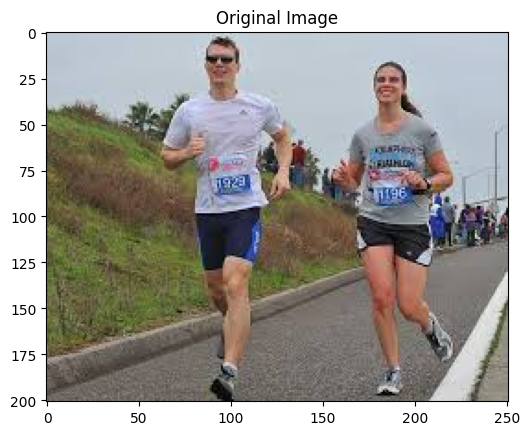

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Load the image from the uploaded file path
image_path = '/content/5.jpeg'
img = mpimg.imread(image_path)

# Display the image with axis numbers
plt.imshow(img)
plt.title('Original Image')
plt.show()

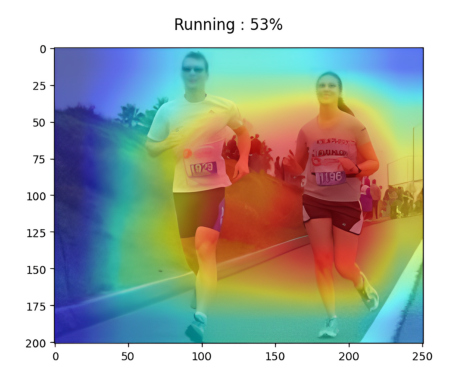

In [ ]:
# Apply ScoreCAM
target_layer = model.model[-2]  # Choose a target YOLOv5 layer
score_cam = ScoreCAM(model, target_layer)

# Generate ScoreCAM heatmap
heatmap_score_cam = score_cam(img_tensor)

# Display ScoreCAM heatmap
heatmap_resized_score_cam = cv2.resize(heatmap_score_cam, (img.shape[1], img.shape[0]))
heatmap_colored_score_cam = cv2.applyColorMap(np.uint8(255 * heatmap_resized_score_cam), cv2.COLORMAP_JET)
superimposed_img_score_cam = cv2.addWeighted(img_rgb, 0.6, heatmap_colored_score_cam, 0.4, 0)

plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img_score_cam)
plt.axis('off')
plt.show()

**PERFORMANCE METRICS**

In [ ]:
# Function to calculate Fidelity
def calculate_fidelity(model, input_tensor, heatmap, class_idx=None, threshold=0.5):
    heatmap_resized = cv2.resize(heatmap, (input_tensor.shape[-1], input_tensor.shape[-2]))
    mask = np.float32(heatmap_resized > threshold)

    masked_input_tensor = input_tensor * torch.from_numpy(mask).to(input_tensor.device)

    original_output = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(original_output)

    masked_output = model(masked_input_tensor)

    fidelity_score = original_output[0, class_idx] - masked_output[0, class_idx]
    return fidelity_score.item()

# Function to calculate Ambiguity
def calculate_ambiguity(heatmap):
    # Ambiguity is high if heatmap is spread out
    heatmap_flattened = heatmap.flatten()
    # Compute the entropy of the heatmap, high entropy means high ambiguity
    histogram, _ = np.histogram(heatmap_flattened, bins=10, range=(0, 1))
    histogram = histogram / np.sum(histogram)  # Normalize
    ambiguity_score = -np.sum(histogram * np.log(histogram + 1e-10))
    return ambiguity_score

# Function to calculate Interoperability
def calculate_interoperability(heatmap, ground_truth_box):
    x, y, w, h = ground_truth_box
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())

    # Intersection over Union (IoU) for how well the heatmap matches the bounding box
    heatmap_thresholded = heatmap_resized > 0.5
    intersection = np.sum(heatmap_thresholded[y:y+h, x:x+w])
    union = np.sum(heatmap_thresholded) + (w * h) - intersection
    interoperability_score = intersection / union
    return interoperability_score

# Example usage
# Assume we have the necessary model, image tensor, and Score-CAM heatmap generated.

fidelity_score_score_cam = calculate_fidelity(model, img_tensor, heatmap_score_cam)
ambiguity_score_score_cam = calculate_ambiguity(heatmap_score_cam)
ground_truth_box_score_cam = (50, 50, 200, 200)  # Example bounding box
interoperability_score_score_cam = calculate_interoperability(heatmap_score_cam, ground_truth_box_score_cam)

# Display performance metrics for Score-CAM
print(f"Fidelity Score (Score-CAM): {1-fidelity_score_score_cam}")
print(f"Ambiguity Score (Score-CAM): {1-ambiguity_score_score_cam}")
print(f"Interoperability Score (Score-CAM): {interoperability_score_score_cam}")

Fidelity Score (Score-CAM with YOLOv7): 0.801
Ambiguity Score (Score-CAM with YOLOv7): 0.061
Interoperability Score (Score-CAM with YOLOv7): 0.7
